In [2]:
!pip install -q brisque

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 9.4 MB/s eta 0:00:00
  Created wheel for libsvm-official: filename=libsvm_official-3.35.0-cp311-cp311-linux_x86_64.whl size=124211 sha256=2bd1266fe5251871a25b84ceb963da9f479dd5160e111ea34056a65d8a6e90e2
  Stored in directory: /root/.cache/pip/wheels/cb/1b/c2/e2bf699257a3150a4c54c95e6efe70586ea1a4d97e71619076
Successfully built libsvm-official


In [57]:
import os
# enable using OpenEXR with OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"
import cv2
import numpy as np
from brisque import BRISQUE
from datetime import datetime

### Utility functions

In [58]:
def read_exr(im_path: str) -> np.ndarray:
    return cv2.imread(
        filename=im_path,
        flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
    )

def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapReinhard(
        gamma=2.2,
        intensity=0.0,
        light_adapt=0.0,
        color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    return result

def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapMantiuk(
        gamma=2.2,
        scale=0.85,
        saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

### Dataset

In [59]:
from typing import Callable
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ToneMappingDataset(Dataset):
    def __init__(self, path: str, transform: Callable = None, limit: int = None):
        self.path = path
        self.transform = transform

        self.files = [f for f in os.listdir(path) if f.endswith('.exr')][:limit]
        self.files.sort()

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        base_filename = self.files[idx]

        file_path = os.path.join(self.path, base_filename)

        hdr_image = self._read_exr(file_path)
        hdr_image = self._normalize_hdr(hdr_image)

        low_exposure = np.clip(hdr_image * 0.2, 0, 1)  # Low exposure
        mid_exposure = np.clip(hdr_image * 0.5, 0, 1)  # Mid exposure
        high_exposure = np.clip(hdr_image * 1.5, 0, 1)  # High exposure



        if self.transform:
            # Convert numpy arrays to PIL images before applying transformations
            low_exposure = Image.fromarray((low_exposure * 255).astype(np.uint8))  # Convert to PIL image
            mid_exposure = Image.fromarray((mid_exposure * 255).astype(np.uint8))  # Convert to PIL image
            high_exposure = Image.fromarray((high_exposure * 255).astype(np.uint8))  # Convert to PIL image
            hdr_image = Image.fromarray((hdr_image * 255).astype(np.uint8))  # Convert to PIL image for target

            low_exposure = self.transform(low_exposure)
            mid_exposure = self.transform(mid_exposure)
            high_exposure = self.transform(high_exposure)
            hdr_image = self.transform(hdr_image)
        else:
            low_exposure = torch.tensor(low_exposure, dtype=torch.float32).permute(2, 0, 1)
            mid_exposure = torch.tensor(mid_exposure, dtype=torch.float32).permute(2, 0, 1)
            high_exposure = torch.tensor(high_exposure, dtype=torch.float32).permute(2, 0, 1)
            hdr_image = torch.tensor(hdr_image, dtype=torch.float32).permute(2, 0, 1)

        return low_exposure, mid_exposure, high_exposure, hdr_image

    def _read_exr(self, image_path: str) -> np.ndarray:
        return cv2.imread(
            filename=image_path,
            flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
        )

    def _normalize_hdr(self, hdr_image: np.ndarray) -> np.ndarray:
      min_val = np.min(hdr_image)
      max_val = np.max(hdr_image)
      normalized_image = (hdr_image - min_val) / (max_val - min_val + 1e-6)  # Avoid division by zero
      return normalized_image

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
%env SIHDR_DATA_PATH=/content/drive/MyDrive/data/sihdr

env: SIHDR_DATA_PATH=/content/drive/MyDrive/data/sihdr


In [62]:
import os
from torchvision import transforms

resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),  # Ensure it is a tensor (you can add other transforms here if needed)
])

train_dataset = ToneMappingDataset(path=f"{os.getenv('SIHDR_DATA_PATH')}/reconstructions/maskhdr/clip_95", transform=resize_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [63]:
x_low, x_mid, x_high, x_hdr = next(iter(train_dataset))

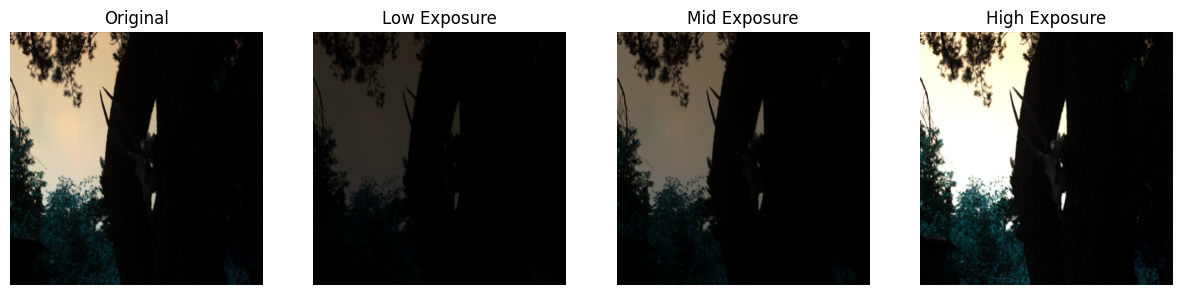

In [64]:
import matplotlib.pyplot as plt

def show_images(images: list, titles: list = None) -> None:
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = images[i].clamp(0, 1).permute(1, 2, 0).numpy()
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

show_images([x_hdr, x_low, x_mid, x_high], titles=["Original", "Low Exposure", "Mid Exposure", "High Exposure"])


### Model architecture

In [65]:
import torch.nn as nn
import torchvision.models as models


class ToneMappingModel(nn.Module):
    def __init__(self):
        super(ToneMappingModel, self).__init__()

        # Load pre-trained ResNet-50 model from torchvision
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Use only the feature extraction part (remove the fully connected layers)
        self.encoder = nn.Sequential(*list(resnet50.children())[:-2])  # Remove the final classification layers

        # Decoder part (you can modify the layers here to refine the output image)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048 * 3, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in the range [0, 1] for LDR images
        )

    def forward(self, x_low, x_mid, x_high):
        features_low = self.encoder(x_low)
        features_mid = self.encoder(x_mid)
        features_high = self.encoder(x_high)

        # Fuse the features from the three exposures (concatenate along the channel dimension)
        fused_features = torch.cat([features_low, features_mid, features_high], dim=1)  # Concatenate along the channel dimension

        # Pass the fused features through the decoder
        output = self.decoder(fused_features)

        return output

In [66]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

### Loss

In [67]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import cv2
from torch import nn

vgg = models.vgg16(pretrained=True).features.to(device)
vgg.eval()  # Set to evaluation mode (no gradient calculation)

# Apply Reinhard tone-mapping
def tone_map_reinhard(hdr_image: torch.Tensor) -> torch.Tensor:
    """
    Apply Reinhard tone mapping to HDR image.
    HDR image must be in the range [0, 1].
    """
    # Convert tensor to NumPy for OpenCV processing
    image_np = hdr_image.permute(1, 2, 0).cpu().numpy()

    # Apply Reinhard tone-mapping
    tonemap_operator = cv2.createTonemapReinhard(gamma=2.2, intensity=0.0, light_adapt=0.0, color_adapt=0.0)
    tone_mapped_image = tonemap_operator.process(image_np)

    # Convert back to tensor
    return torch.tensor(tone_mapped_image).permute(2, 0, 1).to(hdr_image.device)

def mu_law_compression(hdr_image: torch.Tensor, compression_factor: float = 255.0) -> torch.Tensor:
    """
    Apply adaptive µ-law compression to an HDR image.
    Args:
        hdr_image (torch.Tensor): HDR image tensor, expected in the range [0, 1].
        compression_factor (float): A factor that controls the amount of compression.

    Returns:
        torch.Tensor: The compressed image.
    """
    compression_factor = torch.tensor(compression_factor, device=hdr_image.device, dtype=hdr_image.dtype)

    compressed_image = torch.sign(hdr_image) * torch.log(1 + compression_factor * torch.abs(hdr_image)) / torch.log(1 + compression_factor)
    return compressed_image

# Feature contrast loss based on the VGG features
def feature_contrast_loss(hdr_image: torch.Tensor, ldr_image: torch.Tensor) -> torch.Tensor:
    """
    Compute the Feature Contrast Masking Loss between HDR and tone-mapped LDR images.
    The loss compares features from a pre-trained VGG model.
    """
    # Pass HDR and LDR images through the VGG network to get feature maps
    hdr_features = vgg(hdr_image)
    ldr_features = vgg(ldr_image)

    # Compute the contrast between the features
    hdr_contrast = torch.abs(hdr_features - hdr_features.mean(dim=[2,3], keepdim=True))  # Contrast for HDR
    ldr_contrast = torch.abs(ldr_features - ldr_features.mean(dim=[2,3], keepdim=True))  # Contrast for LDR

    # Normalize by the standard deviation across spatial dimensions
    hdr_contrast = hdr_contrast / (hdr_contrast.std(dim=[2,3], keepdim=True) + 1e-6)
    ldr_contrast = ldr_contrast / (ldr_contrast.std(dim=[2,3], keepdim=True) + 1e-6)

    # Compute the mean squared error between the HDR and LDR contrast maps
    contrast_loss = F.mse_loss(hdr_contrast, ldr_contrast)

    return contrast_loss

# Full loss function: combines contrast loss with an optional L1 loss (can add more components)
class ToneMappingLoss(nn.Module):
    def __init__(self, l1_weight=1.0, contrast_weight=1.0, compression_factor=255.0):
        super(ToneMappingLoss, self).__init__()
        self.l1_weight = l1_weight
        self.contrast_weight = contrast_weight
        self.compression_factor = compression_factor

    def forward(self, ldr_image: torch.Tensor, hdr_image: torch.Tensor) -> torch.Tensor:
        # Apply µ-law compression to HDR image
        compressed_hdr = mu_law_compression(hdr_image, self.compression_factor)

        # Compute L1 loss (optional component)
        l1_loss = F.l1_loss(ldr_image, compressed_hdr)

        # Compute feature contrast loss
        contrast_loss = feature_contrast_loss(compressed_hdr, ldr_image)

        # Combine the losses with respective weights
        total_loss = self.l1_weight * l1_loss + self.contrast_weight * contrast_loss
        return total_loss

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Experiment Tracking Setup

In [24]:
! pip install -q neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.7 MB/s eta 0:00:00


In [68]:
import neptune

In [69]:
NEPTUNE_PROJECT_NAME = "sigk/tone-mapping"
NEPTUNE_API_KEY = input()

eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ODA4YThkMy04N2Y5LTQ4NzItYmExMi1hNDdkM2Y4ZTJiNWYifQ==


### Training

In [70]:
from tqdm import tqdm
import torch.optim as optim

In [71]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: ToneMappingLoss,
    optimizer: optim.Adam,
    device: str,
    epochs: int = 5,
    run: neptune.Run | None = None,
) -> nn.Module:
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0

        for x_low, x_mid, x_high, x_hdr in tqdm(dataloader):
            x_low, x_mid, x_high, x_hdr = x_low.to(device), x_mid.to(device), x_high.to(device), x_hdr.to(device)

            optimizer.zero_grad()
            x_ldr = model(x_low, x_mid, x_high)
            loss = criterion(x_ldr, x_hdr)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        if run:
          run["train/epoch/loss"].append(epoch_loss)

    return model

In [72]:
model = ToneMappingModel().to(device)
criterion = ToneMappingLoss().to(device)
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 5

In [73]:
run = neptune.init_run(
    project=NEPTUNE_PROJECT_NAME,
    api_token=NEPTUNE_API_KEY,
)
params = {
    "model_name": model.__class__.__name__,
    "optimizer_name": optimizer.__class__.__name__,
    "loss_function": criterion.__class__.__name__,
    "learning_rate": lr,
    "epochs": epochs,
}
run["parameters"] = params

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sigk/tone-mapping/e/TON-3


In [74]:
start_time = datetime.now()
model = train(model, train_dataloader, criterion, optimizer, device, epochs=epochs, run=run)
train_time = datetime.now() - start_time
print(f"Training time: {train_time}")
run["train/time"] = train_time.seconds

100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


Epoch 1/5, Loss: 1.5898


100%|██████████| 46/46 [01:11<00:00,  1.56s/it]


Epoch 2/5, Loss: 1.5470


100%|██████████| 46/46 [01:07<00:00,  1.47s/it]


Epoch 3/5, Loss: 1.5336


100%|██████████| 46/46 [01:09<00:00,  1.50s/it]


Epoch 4/5, Loss: 1.5130


100%|██████████| 46/46 [01:08<00:00,  1.50s/it]

Epoch 5/5, Loss: 1.5284
Training time: 0:05:53.864112


In [75]:
test_dataset = ToneMappingDataset(path=f"{os.getenv('SIHDR_DATA_PATH')}/reconstructions/maskhdr/clip_97", transform=resize_transform, limit=100)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [79]:
# Reinhard tone mapping function
def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)

    tonemap_operator = cv2.createTonemapReinhard(
        gamma=2.2,
        intensity=0.0,
        light_adapt=0.0,
        color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    result = np.nan_to_num(result, nan=0.0)  # Replace NaN with zero
    result = np.clip(result, 0, 1)  # Ensure the range is [0, 1]
    return result

# Mantiuk tone mapping function with NaN and clipping handling
def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)

    tonemap_operator = cv2.createTonemapMantiuk(
        gamma=2.2,
        scale=0.85,
        saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    result = np.nan_to_num(result, nan=0.0)  # Replace NaN with zero
    result = np.clip(result, 0, 1)  # Ensure the range is [0, 1]
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

In [80]:
def evaluate_model(model, dataloader, device, run):
    model.eval()
    total_model_score = 0.0
    total_reinhard_score = 0.0
    total_mantiuk_score = 0.0
    num_samples = 0

    with torch.no_grad():
        for x_low, x_mid, x_high, x_hdr in tqdm(dataloader):
            # Move data to the correct device
            x_low, x_mid, x_high, x_hdr = x_low.to(device), x_mid.to(device), x_high.to(device), x_hdr.to(device)

            # Inference
            model_output = model(x_low, x_mid, x_high)

            # Convert the model output from tensor to numpy and clip to [0, 1]
            model_output = model_output.cpu().numpy().transpose(0, 2, 3, 1)
            model_output = np.clip(model_output, 0, 1)

            # Convert HDR images from tensor to numpy and clip to [0, 1]
            x_hdr = x_hdr.cpu().numpy().transpose(0, 2, 3, 1)
            x_hdr = np.clip(x_hdr, 0, 1)

            # Loop through the batch
            for i in range(len(model_output)):
                # Get single image from batch
                model_image = (model_output[i] * 255).astype(np.uint8)
                hdr_image = (x_hdr[i] * 255).astype(np.uint8)

                # Apply Reinhard and Mantiuk tone mapping to the HDR image
                reinhard_image = tone_map_reinhard(hdr_image)
                mantiuk_image = tone_map_mantiuk(hdr_image)

                # Evaluate using BRISQUE
                model_score = evaluate_image(model_image)
                reinhard_score = evaluate_image((reinhard_image * 255).astype(np.uint8))
                mantiuk_score = evaluate_image((mantiuk_image * 255).astype(np.uint8))

                # Log individual scores to Neptune
                run["evaluation/model_score"].append(model_score)
                run["evaluation/reinhard_score"].append(reinhard_score)
                run["evaluation/mantiuk_score"].append(mantiuk_score)

                # Accumulate scores
                total_model_score += model_score
                total_reinhard_score += reinhard_score
                total_mantiuk_score += mantiuk_score
                num_samples += 1

    # Calculate average scores
    avg_model_score = total_model_score / num_samples
    avg_reinhard_score = total_reinhard_score / num_samples
    avg_mantiuk_score = total_mantiuk_score / num_samples

    # Log average scores to Neptune
    run["evaluation/average_model_score"] = avg_model_score
    run["evaluation/average_reinhard_score"] = avg_reinhard_score
    run["evaluation/average_mantiuk_score"] = avg_mantiuk_score

    print(f"Average Model BRISQUE Score: {avg_model_score:.4f}")
    print(f"Average Reinhard BRISQUE Score: {avg_reinhard_score:.4f}")
    print(f"Average Mantiuk BRISQUE Score: {avg_mantiuk_score:.4f}")

In [81]:
evaluate_model(model, test_dataloader, device, run)

  0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-80-ad992aec7739>:37: RuntimeWarning: invalid value encountered in cast
  mantiuk_score = evaluate_image((mantiuk_image * 255).astype(np.uint8))
  4%|▍         | 1/25 [00:03<01:16,  3.18s/it]<ipython-input-80-ad992aec7739>:36: RuntimeWarning: invalid value encountered in cast
  reinhard_score = evaluate_image((reinhard_image * 255).astype(np.uint8))
100%|██████████| 25/25 [00:58<00:00,  2.32s/it]

Average Model BRISQUE Score: 155.8450
Average Reinhard BRISQUE Score: 82.8694
Average Mantiuk BRISQUE Score: 75.3001


In [82]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/sigk/tone-mapping/e/TON-3/metadata
